# PROTAC-Degradation-Predictor

In [1]:
import pandas as pd

protac_df = pd.read_csv('../data/processed/PROTAC-Degradation-DB.csv')
protac_df.head()

,Compound ID,Uniprot,Smiles,E3 Ligase,InChI,InChI Key,Molecular Weight,Heavy Atom Count,Ring Count,Rotatable Bond Count,...,PDB,Name,Assay (DC50/Dmax),Exact Mass,XLogP3,Target (Parsed),POI Sequence,E3 Ligase Uniprot,E3 Ligase Sequence,Cell Line Identifier
0,1,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C73H88ClF3N10O10S4/c1-47(49-13-15-51(...,SXPDUCVNMGMWBJ-FMZBIETASA-N,1486.282,101,10,24,...,NaN,NaN,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4
1,2,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C74H90ClF3N10O10S4/c1-48(50-13-15-52(...,HQKUMELJMUNTTF-NMKDNUEVSA-N,1500.309,102,10,25,...,NaN,NaN,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4
2,3,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C75H92ClF3N10O10S4/c1-49(51-16-18-53(...,ATQCEJKUPSBDMA-QARNUTPLSA-N,1514.336,103,10,26,...,NaN,NaN,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4
3,4,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C76H94ClF3N10O10S4/c1-50(52-17-19-54(...,FNKQAGMHNFFSEI-DTTPTBRMSA-N,1528.363,104,10,27,...,NaN,NaN,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4
4,5,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C77H96ClF3N10O10S4/c1-51(53-18-20-55(...,PXVFFBGSTYQHRO-REQIQPEASA-N,1542.390,105,10,28,...,NaN,NaN,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4


In [2]:
protac_df.columns

Index(['Compound ID', 'Uniprot', 'Smiles', 'E3 Ligase', 'InChI', 'InChI Key',
       'Molecular Weight', 'Heavy Atom Count', 'Ring Count',
       'Rotatable Bond Count', 'Topological Polar Surface Area',
       'Hydrogen Bond Acceptor Count', 'Hydrogen Bond Donor Count',
       'Cell Type', 'Treatment Time (h)', 'DC50 (nM)', 'Dmax (%)', 'Active',
       'Article DOI', 'Comments', 'Database', 'Molecular Formula', 'cLogP',
       'Target', 'PDB', 'Name', 'Assay (DC50/Dmax)', 'Exact Mass', 'XLogP3',
       'Target (Parsed)', 'POI Sequence', 'E3 Ligase Uniprot',
       'E3 Ligase Sequence', 'Cell Line Identifier'],
      dtype='object')

In [3]:
cells = sorted(protac_df['Cell Type'].dropna().unique().tolist())
print(f'Number of non-cleaned cell lines: {len(cells)}')

Number of non-cleaned cell lines: 180


In [4]:
cells = sorted(protac_df['Cell Line Identifier'].dropna().unique().tolist())
print(f'Number of cleaned cell lines: {len(cells)}')

Number of cleaned cell lines: 138


In [5]:
test_df = protac_df[protac_df['Active'].isna()]
print(f'Number of compounds in test set: {len(test_df)}')

Number of compounds in test set: 1054


## Load Protein Embeddings

Protein embeddings downloaded from [Uniprot](https://www.uniprot.org/help/embeddings).

In [6]:
import h5py
import numpy as np
from tqdm.auto import tqdm

protein_embeddings = {}
with h5py.File("../data/raw/per-protein-embeddings.h5", "r") as file:
    print(f"number of entries: {len(file.items()):,}")
    uniprots = protac_df['Uniprot'].unique().tolist()
    uniprots += protac_df['E3 Ligase Uniprot'].unique().tolist()
    for i, sequence_id in tqdm(enumerate(uniprots), desc='Loading protein embeddings'):
        try:
            embedding = file[sequence_id][:]
            protein_embeddings[sequence_id] = np.array(embedding)
            if i < 10:
                print(
                    f"\tid: {sequence_id}, "
                    f"\tembeddings shape: {embedding.shape}, "
                    f"\tembeddings mean: {np.array(embedding).mean()}"
                )
        except KeyError:
            print(f'KeyError for {sequence_id}')
            protein_embeddings[sequence_id] = np.zeros((1024,))

number of entries: 570,820


Loading protein embeddings: 0it [00:00, ?it/s]

	id: Q07817, 	embeddings shape: (1024,), 	embeddings mean: -0.0005669593811035156
	id: P00533, 	embeddings shape: (1024,), 	embeddings mean: 0.001171112060546875
	id: Q9NWZ3, 	embeddings shape: (1024,), 	embeddings mean: 0.00041985511779785156
	id: P00519, 	embeddings shape: (1024,), 	embeddings mean: 0.0009608268737792969
	id: P11474, 	embeddings shape: (1024,), 	embeddings mean: -0.0018215179443359375
	id: Q16288, 	embeddings shape: (1024,), 	embeddings mean: 0.0010204315185546875
	id: O60674, 	embeddings shape: (1024,), 	embeddings mean: 0.0015687942504882812
	id: Q06187, 	embeddings shape: (1024,), 	embeddings mean: 0.0006914138793945312
	id: Q9UHD2, 	embeddings shape: (1024,), 	embeddings mean: 0.0012235641479492188
	id: Q8IXJ6, 	embeddings shape: (1024,), 	embeddings mean: -0.00042366981506347656
KeyError for A8DG50


## Load Cell Embeddings

In [7]:
import pickle

cell2embedding_filepath = '../data/processed/cell2embedding.pkl'
with open(cell2embedding_filepath, 'rb') as f:
    cell2embedding = pickle.load(f)
print(f'Loaded {len(cell2embedding)} cell lines')

Loaded 1138 cell lines


In [8]:
emb_shape = cell2embedding[list(cell2embedding.keys())[0]].shape
# Assign all-zero vectors to cell lines that are not in the embedding file
for cell_line in protac_df['Cell Line Identifier'].unique():
    if cell_line not in cell2embedding:
        cell2embedding[cell_line] = np.zeros(emb_shape)

## Precompute Molecular Fingerprints

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

smiles2fp = {}
for smiles in tqdm(protac_df['Smiles'].unique().tolist(), desc='Precomputing fingerprints'):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=1024)
    fp = np.array(fp)
    smiles2fp[smiles] = fp

Precomputing fingerprints:   0%|          | 0/1467 [00:00<?, ?it/s]

## UMAP-ing

In [10]:
import umap
from sklearn.preprocessing import StandardScaler

c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\umap\distances.py:1086: Num

In [11]:
protac_data = []
protac_labels = []
for _, row in protac_df.iterrows():
    if pd.notnull(row['Active']):
        protac_labels.append(row['Active'])
        protac_data.append(
            np.concatenate([
                protein_embeddings[row['Uniprot']],
                protein_embeddings[row['E3 Ligase Uniprot']],
                cell2embedding[row['Cell Line Identifier']],
                smiles2fp[row['Smiles']],
            ])
        )
protac_data = np.array(protac_data)

In [12]:
# Define UMAP and Scaler
umap_reducer = umap.UMAP(
    n_neighbors=50,  # Good value: 50
    min_dist=0.5,  # Good value: 0.5
    # spread=1.0, # Good value: (not set, default)
    metric='euclidean',
    random_state=42,
    unique=True,
    # n_epochs=100,
    init='spectral',  # Default: 'spectral'
    learning_rate=0.8,  # Default: 1.0
    verbose=False,
)
scaler = StandardScaler()

# Get the embeddings as a numpy array
data = scaler.fit_transform(protac_data)
data = umap_reducer.fit_transform(data)

# Get the UMAP embedding coordinates
umap_embeddings = {
    'UMAP 1': [],
    'UMAP 2': [],
    'Active': [],
}
umap_embeddings['UMAP 1'] = data[:, 0].tolist()
umap_embeddings['UMAP 2'] = data[:, 1].tolist()
umap_embeddings['Active'] = protac_labels

# Transform to dataframe and drop duplicates
umap_embeddings = pd.DataFrame(umap_embeddings).drop_duplicates()
umap_embeddings.head()

,UMAP 1,UMAP 2,Active
0,-2.063828,0.469916,True
1,-2.112080,0.532322,True
2,3.770336,2.801539,False
3,2.661749,1.402914,False
4,2.853118,1.610319,True


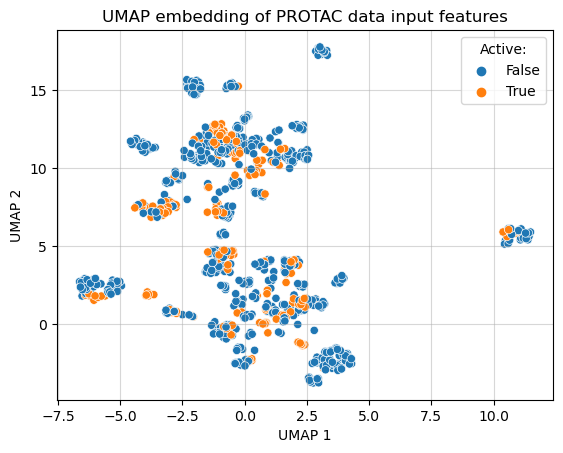

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.scatterplot(data=umap_embeddings, x='UMAP 1', y='UMAP 2',
                    hue='Active', palette=sns.color_palette('tab10'))
    # Make the legend external
    plt.legend(title='Active:')
    plt.title('UMAP embedding of PROTAC data input features')
    plt.grid(axis='both', alpha=0.5)
    plt.show()

## PCA (TODO)

## Define Torch Dataset

In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

In [15]:
from torch.utils.data import Dataset, DataLoader


class PROTAC_Dataset(Dataset):
    def __init__(
        self,
        protac_df,
        protein_embeddings,
        cell2embedding,
        smiles2fp,
        use_smote=False,
    ):
        # Filter out examples with NaN in 'Active' column
        self.data = protac_df  # [~protac_df['Active'].isna()]
        self.protein_embeddings = protein_embeddings
        self.cell2embedding = cell2embedding
        self.smiles2fp = smiles2fp

        self.smiles_emb_dim = smiles2fp[list(smiles2fp.keys())[0]].shape[0]
        self.protein_emb_dim = protein_embeddings[list(
            protein_embeddings.keys())[0]].shape[0]
        self.cell_emb_dim = cell2embedding[list(
            cell2embedding.keys())[0]].shape[0]

        # print(f'SMILES embedding dimension: {self.smiles_emb_dim}')
        # print(f'Protein embedding dimension: {self.protein_emb_dim}')
        # print(f'Cell embedding dimension: {self.cell_emb_dim}')

        self.use_smote = use_smote
        # Apply SMOTE
        if self.use_smote:
            self.apply_smote()

    def apply_smote(self):
        # Prepare the dataset for SMOTE
        features = []
        labels = []
        for idx, row in self.data.iterrows():
            smiles_emb = smiles2fp[row['Smiles']]
            poi_emb = protein_embeddings[row['Uniprot']]
            e3_emb = protein_embeddings[row['E3 Ligase Uniprot']]
            cell_emb = cell2embedding[row['Cell Line Identifier']]
            features.append(np.hstack([
                smiles_emb.astype(np.float32),
                poi_emb.astype(np.float32),
                e3_emb.astype(np.float32),
                cell_emb.astype(np.float32),
            ]))
            labels.append(row['Active'])

        # Convert to numpy array
        features = np.array(features).astype(np.float32)
        labels = np.array(labels).astype(np.float32)

        # Initialize SMOTE and fit
        smote = SMOTE(random_state=42, n_jobs=-1)
        features_smote, labels_smote = smote.fit_resample(features, labels)

        # Separate the features back into their respective embeddings
        smiles_embs = features_smote[:, :self.smiles_emb_dim]
        poi_embs = features_smote[:,
                                  self.smiles_emb_dim:self.smiles_emb_dim+self.protein_emb_dim]
        e3_embs = features_smote[:, self.smiles_emb_dim +
                                 self.protein_emb_dim:self.smiles_emb_dim+2*self.protein_emb_dim]
        cell_embs = features_smote[:, -self.cell_emb_dim:]

        # Reconstruct the dataframe with oversampled data
        df_smote = pd.DataFrame({
            'Smiles': list(smiles_embs),
            'Uniprot': list(poi_embs),
            'E3 Ligase Uniprot': list(e3_embs),
            'Cell Line Identifier': list(cell_embs),
            'Active': labels_smote
        })
        self.data = df_smote

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.use_smote:
            # NOTE: We do not need to look up the embeddings anymore
            elem = {
                'smiles_emb': self.data['Smiles'].iloc[idx],
                'poi_emb': self.data['Uniprot'].iloc[idx],
                'e3_emb': self.data['E3 Ligase Uniprot'].iloc[idx],
                'cell_emb': self.data['Cell Line Identifier'].iloc[idx],
                'active': 1. if self.data['Active'].iloc[idx] else 0.,
            }
        else:
            elem = {
                'smiles_emb': self.smiles2fp[self.data['Smiles'].iloc[idx]].astype(np.float32),
                'poi_emb': self.protein_embeddings[self.data['Uniprot'].iloc[idx]].astype(np.float32),
                'e3_emb': self.protein_embeddings[self.data['E3 Ligase Uniprot'].iloc[idx]].astype(np.float32),
                'cell_emb': self.cell2embedding[self.data['Cell Line Identifier'].iloc[idx]].astype(np.float32),
                'active': 1. if self.data['Active'].iloc[idx] else 0.,
            }
        return elem


protac_ds = PROTAC_Dataset(
    protac_df[protac_df['Active'].notna()], protein_embeddings, cell2embedding, smiles2fp, use_smote=True)
print(f'Loaded {len(protac_ds)} PROTACs')

c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Loaded 1614 PROTACs


In [17]:
protac_ds = PROTAC_Dataset(
    protac_df[~protac_df['Active'].isna()], protein_embeddings, cell2embedding, smiles2fp, use_smote=True)
print(f'Loaded {len(protac_ds)} PROTACs')

Loaded 1614 PROTACs


c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [18]:
protac_ds[42]

{'smiles_emb': array([0., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'poi_emb': array([ 0.00964355,  0.00894928,  0.00073957, ..., -0.03030396,
        -0.00224686, -0.02049255], dtype=float32),
 'e3_emb': array([ 0.00413132,  0.03634644,  0.09191895, ..., -0.04534912,
         0.08526611,  0.03466797], dtype=float32),
 'cell_emb': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [19]:
protac_dl = DataLoader(protac_ds, batch_size=32, shuffle=True)
print(f'Example batch: {next(iter(protac_dl))}')

Example batch: {'smiles_emb': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.8655,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 0.0000]]), 'poi_emb': tensor([[ 0.0132,  0.0703,  0.0471,  ..., -0.0115, -0.0242, -0.0089],
        [ 0.0133,  0.0191,  0.0097,  ..., -0.0234, -0.0029, -0.0141],
        [ 0.0132,  0.0703,  0.0471,  ..., -0.0115, -0.0242, -0.0089],
        ...,
        [ 0.0427,  0.0529,  0.0352,  ..., -0.0147, -0.0024,  0.0115],
        [ 0.0132,  0.0703,  0.0471,  ..., -0.0115, -0.0242, -0.0089],
        [ 0.0132,  0.0703,  0.0471,  ..., -0.0115, -0.0242, -0.0089]]), 'e3_emb': tensor([[ 0.0331,  0.0391,  0.0448,  ..., -0.0251, -0.0331,  0.0293],
        [ 0.0041,  0.0363,  0.0919,  ..., -0.

In [20]:
batch = next(iter(protac_dl))
print(batch['smiles_emb'])
print(batch['smiles_emb'].size())

tensor([[0., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 1., 0.]])
torch.Size([32, 1024])


## Define PyTorch Lightning Model

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torchmetrics import (
    Accuracy,
    AUROC,
    Precision,
    Recall,
    F1Score,
)
from torchmetrics import MetricCollection


class PROTAC_Model(pl.LightningModule):

    def __init__(
        self,
        hidden_dim,
        smiles_emb_dim=1024,
        poi_emb_dim=1024,
        e3_emb_dim=1024,
        cell_emb_dim=768,
        batch_size=32,
        learning_rate=1e-3,
        dropout=0.2,
        train_dataset=None,
        val_dataset=None,
        test_dataset=None,
        disabled_embeddings=[],
    ):
        super().__init__()
        self.poi_emb_dim = poi_emb_dim
        self.e3_emb_dim = e3_emb_dim
        self.cell_emb_dim = cell_emb_dim
        self.smiles_emb_dim = smiles_emb_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.disabled_embeddings = disabled_embeddings
        # Set our init args as class attributes
        self.__dict__.update(locals())  # Add arguments as attributes
        # Save the arguments passed to init
        ignore_args_as_hyperparams = [
            'train_dataset',
            'test_dataset',
            'val_dataset',
        ]
        self.save_hyperparameters(ignore=ignore_args_as_hyperparams)

        if 'poi' not in self.disabled_embeddings:
            self.poi_emb = nn.Linear(poi_emb_dim, hidden_dim)
        if 'e3' not in self.disabled_embeddings:
            self.e3_emb = nn.Linear(e3_emb_dim, hidden_dim)
        if 'cell' not in self.disabled_embeddings:
            self.cell_emb = nn.Linear(cell_emb_dim, hidden_dim)
        if 'smiles' not in self.disabled_embeddings:
            self.smiles_emb = nn.Linear(smiles_emb_dim, hidden_dim)

        self.fc1 = nn.Linear(
            hidden_dim * (4 - len(self.disabled_embeddings)), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

        self.dropout = nn.Dropout(p=dropout)

        stages = ['train_metrics', 'val_metrics', 'test_metrics']
        self.metrics = nn.ModuleDict({s: MetricCollection({
            'acc': Accuracy(task='binary'),
            'roc_auc': AUROC(task='binary'),
            'precision': Precision(task='binary'),
            'recall': Recall(task='binary'),
            'f1_score': F1Score(task='binary'),
            'opt_score': Accuracy(task='binary') + F1Score(task='binary'),
            'hp_metric': Accuracy(task='binary'),
        }, prefix=s.replace('metrics', '')) for s in stages})

        # Misc settings
        self.missing_dataset_error = \
            '''Class variable `{0}` is None. If the model was loaded from a checkpoint, the dataset must be set manually:
            
            model = {1}.load_from_checkpoint('checkpoint.ckpt')
            model.{0} = my_{0}
            '''

    def forward(self, poi_emb, e3_emb, cell_emb, smiles_emb):
        embeddings = []
        if 'poi' not in self.disabled_embeddings:
            embeddings.append(self.dropout(self.poi_emb(poi_emb)))
        if 'e3' not in self.disabled_embeddings:
            embeddings.append(self.dropout(self.e3_emb(e3_emb)))
        if 'cell' not in self.disabled_embeddings:
            embeddings.append(self.dropout(self.cell_emb(cell_emb)))
        if 'smiles' not in self.disabled_embeddings:
            embeddings.append(self.dropout(self.smiles_emb(smiles_emb)))
        x = torch.cat(embeddings, dim=1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

    def step(self, batch, batch_idx, stage):
        poi_emb = batch['poi_emb']
        e3_emb = batch['e3_emb']
        cell_emb = batch['cell_emb']
        smiles_emb = batch['smiles_emb']
        y = batch['active'].float().unsqueeze(1)

        y_hat = self.forward(poi_emb, e3_emb, cell_emb, smiles_emb)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)

        self.metrics[f'{stage}_metrics'].update(y_hat, y)
        self.log(f'{stage}_loss', loss, on_epoch=True, prog_bar=True)
        self.log_dict(self.metrics[f'{stage}_metrics'], on_epoch=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'test')

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

    def predict_step(self, batch, batch_idx):
        poi_emb = batch['poi_emb']
        e3_emb = batch['e3_emb']
        cell_emb = batch['cell_emb']
        smiles_emb = batch['smiles_emb']

        y_hat = self.forward(poi_emb, e3_emb, cell_emb, smiles_emb)
        return torch.sigmoid(y_hat)

    def train_dataloader(self):
        if self.train_dataset is None:
            format = 'train_dataset', self.__class__.__name__
            raise ValueError(self.missing_dataset_error.format(*format))
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True,
        )

    def val_dataloader(self):
        if self.val_dataset is None:
            format = 'val_dataset', self.__class__.__name__
            raise ValueError(self.missing_dataset_error.format(*format))
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        if self.test_dataset is None:
            format = 'test_dataset', self.__class__.__name__
            raise ValueError(self.missing_dataset_error.format(*format))
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

## Train Model

In [106]:
# Split the dataset into train, val, and test
from sklearn.model_selection import train_test_split


train_df, val_df = train_test_split(
    protac_df[protac_df['Active'].notna()], test_size=0.2, random_state=42)
print(f"protac_df.shape: {protac_df.shape}")
print(f"train_df.shape: {train_df.shape}")
print(f"val_df.shape: {val_df.shape}")

protac_df.shape: (2141, 34)
train_df.shape: (869, 34)
val_df.shape: (218, 34)


In [31]:
train_ds = PROTAC_Dataset(
    train_df,
    protein_embeddings,
    cell2embedding,
    smiles2fp,
    use_smote=True,
)
val_ds = PROTAC_Dataset(
    val_df,
    protein_embeddings,
    cell2embedding,
    smiles2fp,
)

In [32]:
logger = pl.loggers.TensorBoardLogger(
    save_dir='../logs',
    name='protac',
)

callbacks = [
    pl.callbacks.EarlyStopping(
        monitor='train_loss',
        patience=10,
        mode='max',
        verbose=True,
    ),
    pl.callbacks.ModelCheckpoint(
        monitor='val_acc',
        mode='max',
        verbose=True,
        filename='{epoch}-{val_metrics_opt_score:.4f}',
    ),
]
# Define Trainer
trainer = pl.Trainer(
    logger=logger,
    callbacks=callbacks,
    max_epochs=50,)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:
model = PROTAC_Model(
    hidden_dim=768,
    smiles_emb_dim=1024,
    poi_emb_dim=1024,
    e3_emb_dim=1024,
    cell_emb_dim=768,
    batch_size=8,
    learning_rate=2e-5,
    train_dataset=train_ds,
    val_dataset=val_ds,
)
# Get model parameters size
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Number of parameters: 5,903,617


In [34]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.681
Epoch 0, global step 162: 'val_acc' reached 0.66055 (best 0.66055), saving model to '../logs\\protac\\version_12\\checkpoints\\epoch=0-val_metrics_opt_score=0.0000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 324: 'val_acc' reached 0.82569 (best 0.82569), saving model to '../logs\\protac\\version_12\\checkpoints\\epoch=1-val_metrics_opt_score=0.0000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 486: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 648: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 810: 'val_acc' reached 0.83028 (best 0.83028), saving model to '../logs\\protac\\version_12\\checkpoints\\epoch=4-val_metrics_opt_score=0.0000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 972: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 1134: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 1296: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1458: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 1620: 'val_acc' was not in top 1


Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.681. Signaling Trainer to stop.
Epoch 10, global step 1782: 'val_acc' reached 0.85321 (best 0.85321), saving model to '../logs\\protac\\version_12\\checkpoints\\epoch=10-val_metrics_opt_score=0.0000.ckpt' as top 1


In [ ]:
# Open tensorboard
%load_ext tensorboard

## Evaluate Model

In [46]:
# Get model predictions on the validation set using the trainer
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
val_preds = trainer.predict(model, val_dl)
val_preds = torch.vstack(val_preds).numpy().flatten()

train_dl = DataLoader(train_ds, batch_size=32, shuffle=False)
train_preds = trainer.predict(model, train_dl)
train_preds = torch.vstack(train_preds).numpy().flatten()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [47]:
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
trainer.validate(model, val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.853210985660553     │
│       val_f1_score        │    0.7288135886192322     │
│       val_hp_metric       │     0.853210985660553     │
│         val_loss          │    0.39718419313430786    │
│       val_opt_score       │    1.5820245742797852     │
│       val_precision       │    0.7413793206214905     │
│        val_recall         │    0.7166666388511658     │
│        val_roc_auc        │    0.9084388017654419     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.39718419313430786,
  'val_acc': 0.853210985660553,
  'val_f1_score': 0.7288135886192322,
  'val_hp_metric': 0.853210985660553,
  'val_opt_score': 1.5820245742797852,
  'val_precision': 0.7413793206214905,
  'val_recall': 0.7166666388511658,
  'val_roc_auc': 0.9084388017654419}]

In [77]:
test_df['Active'] = False
test_ds = PROTAC_Dataset(
    test_df,
    protein_embeddings,
    cell2embedding,
    smiles2fp,
)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)
test_preds = trainer.predict(model, test_dl)
test_preds = torch.vstack(test_preds).numpy().flatten()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

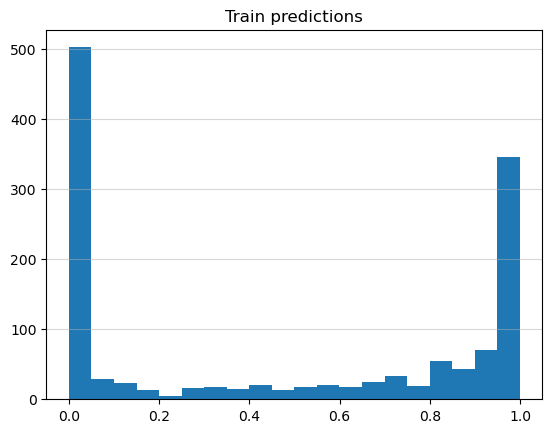

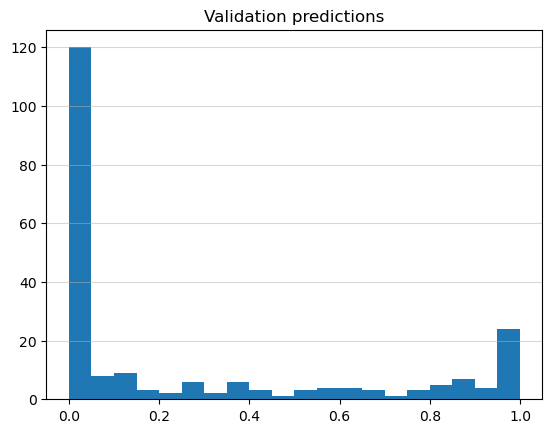

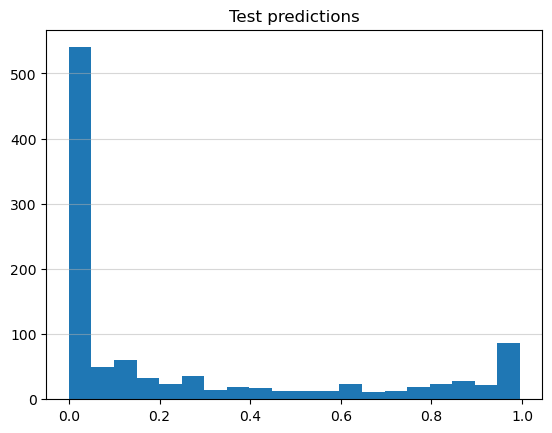

In [78]:
import matplotlib.pyplot as plt

# Plot histogram of predictions
plt.hist(train_preds, bins=20)
plt.title('Train predictions')
plt.grid(axis='y', alpha=0.5)
plt.show()

plt.hist(val_preds, bins=20)
plt.title('Validation predictions')
plt.grid(axis='y', alpha=0.5)
plt.show()

plt.hist(test_preds, bins=20)
plt.title('Test predictions')
plt.grid(axis='y', alpha=0.5)
plt.show()

TODO: Which data are in the most unsure middle region?

In [94]:
# Get the test set predictions which are very confident
def is_active(p, pos_threshold=0.90, neg_threshold=0.005):
    if p > pos_threshold:
        return True
    elif p < neg_threshold:
        return False
    else:
        return np.nan


test_df['Active'] = [
    is_active(p, pos_threshold=0.97, neg_threshold=0.001) for p in test_preds]
test_df[~test_df['Active'].isna()]['Active'].value_counts()

False    130
True      65
Name: Active, dtype: int64

## Cross-Validation Training

TODO: Cross-Val

* Random split
* Least Tanimoto dist PROTAC-wise
* POI-wise: some POIs never in both splits

TODO: Separate test set??

In [22]:
# Seed everything in pytorch lightning
pl.seed_everything(42)


def train_model(train_df, val_df, disabled_embeddings=[]):
    train_ds = PROTAC_Dataset(
        train_df,
        protein_embeddings,
        cell2embedding,
        smiles2fp,
        use_smote=True,
    )
    val_ds = PROTAC_Dataset(
        val_df,
        protein_embeddings,
        cell2embedding,
        smiles2fp,
    )
    logger = pl.loggers.TensorBoardLogger(
        save_dir='../logs',
        name='protac',
    )
    callbacks = [
        pl.callbacks.EarlyStopping(
            monitor='train_loss',
            patience=10,
            mode='max',
            verbose=True,
        ),
        # pl.callbacks.ModelCheckpoint(
        #     monitor='val_acc',
        #     mode='max',
        #     verbose=True,
        #     filename='{epoch}-{val_metrics_opt_score:.4f}',
        # ),
    ]
    # Define Trainer
    trainer = pl.Trainer(
        logger=logger,
        callbacks=callbacks,
        max_epochs=50,
        enable_checkpointing=False,
    )
    model = PROTAC_Model(
        hidden_dim=768,
        smiles_emb_dim=1024,
        poi_emb_dim=1024,
        e3_emb_dim=1024,
        cell_emb_dim=768,
        batch_size=8,
        learning_rate=2e-5,
        train_dataset=train_ds,
        val_dataset=val_ds,
        disabled_embeddings=disabled_embeddings,
    )
    trainer.fit(model)
    val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
    return model, trainer, trainer.validate(model, val_dl)[0]

Global seed set to 42


In [130]:
# K-fold cross-validation loop
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
val_metrics = []
tmp = protac_df[protac_df['Active'].notna()]
for k, (train_index, val_index) in enumerate(kf.split(tmp)):
    train_df = tmp.iloc[train_index]
    val_df = tmp.iloc[val_index]
    model, trainer, val_metric = train_model(train_df, val_df)
    val_metric['fold'] = k
    val_metrics.append(val_metric)
val_metrics = pd.DataFrame(val_metrics)
val_metrics.to_csv(
    f'../data/results/val_metrics_{n_splits}-splits.csv', index=False)
val_metrics.aggregate(['mean', 'std'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.678


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.678. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8623853325843811     │
│       val_f1_score        │    0.7368420958518982     │
│       val_hp_metric       │    0.8623853325843811     │
│         val_loss          │    0.3256032466888428     │
│       val_opt_score       │    1.5992274284362793     │
│       val_precision       │    0.8399999737739563     │
│        val_recall         │          0.65625          │
│        val_roc_auc        │    0.9358766078948975     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.681


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.681. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8440366983413696     │
│       val_f1_score        │    0.7301587462425232     │
│       val_hp_metric       │    0.8440366983413696     │
│         val_loss          │    0.4012793004512787     │
│       val_opt_score       │     1.574195384979248     │
│       val_precision       │    0.6571428775787354     │
│        val_recall         │    0.8214285969734192     │
│        val_roc_auc        │    0.9135802388191223     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.678


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.678. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8256880640983582     │
│       val_f1_score        │    0.6779661178588867     │
│       val_hp_metric       │    0.8256880640983582     │
│         val_loss          │    0.46647822856903076    │
│       val_opt_score       │    1.5036542415618896     │
│       val_precision       │    0.7142857313156128     │
│        val_recall         │    0.6451612710952759     │
│        val_roc_auc        │    0.8873035907745361     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.679


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.679. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8623853325843811     │
│       val_f1_score        │    0.7368420958518982     │
│       val_hp_metric       │    0.8623853325843811     │
│         val_loss          │    0.4182129204273224     │
│       val_opt_score       │    1.5992274284362793     │
│       val_precision       │    0.6176470518112183     │
│        val_recall         │    0.9130434989929199     │
│        val_roc_auc        │    0.9155712723731995     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.677


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.677. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8348624110221863     │
│       val_f1_score        │    0.7272727489471436     │
│       val_hp_metric       │    0.8348624110221863     │
│         val_loss          │    0.40080317854881287    │
│       val_opt_score       │    1.5621352195739746     │
│       val_precision       │    0.6486486196517944     │
│        val_recall         │    0.8275862336158752     │
│        val_roc_auc        │    0.9105603098869324     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.678


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.678. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8256880640983582     │
│       val_f1_score        │    0.7076923251152039     │
│       val_hp_metric       │    0.8256880640983582     │
│         val_loss          │    0.4778938293457031     │
│       val_opt_score       │     1.533380389213562     │
│       val_precision       │    0.6216216087341309     │
│        val_recall         │    0.8214285969734192     │
│        val_roc_auc        │     0.899470865726471     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.676


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.676. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8165137767791748     │
│       val_f1_score        │    0.6969696879386902     │
│       val_hp_metric       │    0.8165137767791748     │
│         val_loss          │    0.5011997222900391     │
│       val_opt_score       │    1.5134835243225098     │
│       val_precision       │    0.6388888955116272     │
│        val_recall         │    0.7666666507720947     │
│        val_roc_auc        │    0.8742616176605225     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.679


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.679. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8148148059844971     │
│       val_f1_score        │    0.6296296119689941     │
│       val_hp_metric       │    0.8148148059844971     │
│         val_loss          │    0.4128589630126953     │
│       val_opt_score       │    1.4444444179534912     │
│       val_precision       │    0.48571428656578064    │
│        val_recall         │    0.8947368264198303     │
│        val_roc_auc        │     0.932584285736084     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.678


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.678. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8703703880310059     │
│       val_f1_score        │    0.7941176295280457     │
│       val_hp_metric       │    0.8703703880310059     │
│         val_loss          │    0.3084067702293396     │
│       val_opt_score       │    1.6644880771636963     │
│       val_precision       │     0.692307710647583     │
│        val_recall         │     0.931034505367279     │
│        val_roc_auc        │    0.9456568956375122     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.676


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.676. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7962962985038757     │
│       val_f1_score        │    0.6764705777168274     │
│       val_hp_metric       │    0.7962962985038757     │
│         val_loss          │    0.45846864581108093    │
│       val_opt_score       │    1.4727668762207031     │
│       val_precision       │    0.6216216087341309     │
│        val_recall         │    0.7419354915618896     │
│        val_roc_auc        │    0.8856305480003357     │
└───────────────────────────┴───────────────────────────┘

,val_loss,val_acc,val_f1_score,val_hp_metric,val_opt_score,val_precision,val_recall,val_roc_auc,fold
mean,0.417120,0.835304,0.711396,0.835304,1.5467,0.653788,0.801927,0.910050,4.50000
std,0.062928,0.024158,0.044705,0.024158,0.0662,0.089258,0.099826,0.023552,3.02765


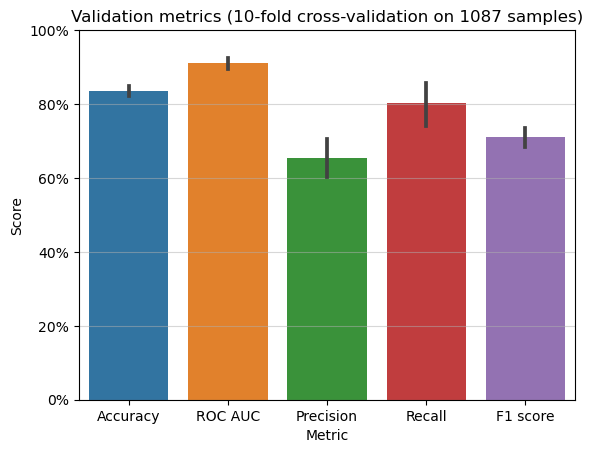

In [131]:
# Plot aggregated results
import seaborn as sns
import matplotlib.pyplot as plt

for n_splits in [5, 10]:
    val_metrics = pd.read_csv(
        f'../data/results/val_metrics_{n_splits}-splits_ablation.csv'
    )

    tmp = val_metrics.copy()[['fold', 'val_acc', 'val_roc_auc',
                              'val_precision', 'val_recall', 'val_f1_score']]
    # Rename columns
    tmp.columns = ['fold', 'Accuracy', 'ROC AUC',
                   'Precision', 'Recall', 'F1 score']
    # Plot aggregated mean value of all metrics in one bar plot
    tmp = tmp.melt(id_vars='fold', var_name='Metric', value_name='Score')

    sns.barplot(data=tmp, x='Metric', y='Score')

    num_data = len(protac_df[protac_df['Active'].notna()])
    plt.title(
        f'Validation metrics ({n_splits}-fold cross-validation on {num_data} samples)')
    plt.grid(axis='y', alpha=0.5)
    # Set y-axis to end at 1.0
    plt.ylim(0, 1.0)
    # Make the y-axis as percentage
    plt.gca().yaxis.set_major_formatter(
        plt.matplotlib.ticker.PercentFormatter(1, decimals=0))
    plt.show()

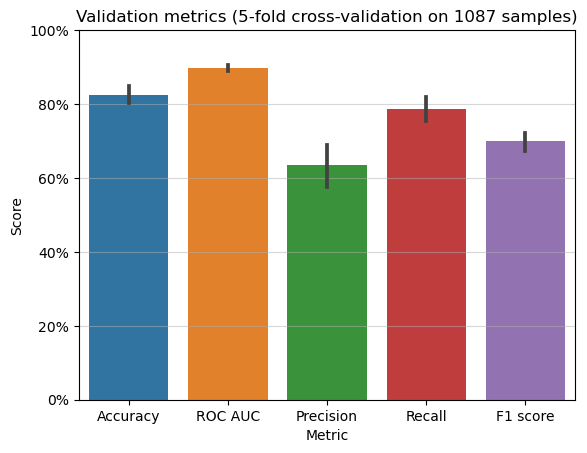

In [126]:
# Plot aggregated results
import seaborn as sns
import matplotlib.pyplot as plt

n_splits = 5
val_metrics = pd.read_csv(
    f'../data/results/val_metrics_{n_splits}-splits_ablation.csv'
)

tmp = val_metrics.copy()[['fold', 'val_acc', 'val_roc_auc',
                          'val_precision', 'val_recall', 'val_f1_score']]
# Rename columns
tmp.columns = ['fold', 'Accuracy', 'ROC AUC',
               'Precision', 'Recall', 'F1 score']
# Plot aggregated mean value of all metrics in one bar plot
tmp = tmp.melt(id_vars='fold', var_name='Metric', value_name='Score')

sns.barplot(data=tmp, x='Metric', y='Score')


num_data = len(protac_df[protac_df['Active'].notna()])
plt.title(
    f'Validation metrics ({n_splits}-fold cross-validation on {num_data} samples)')
plt.grid(axis='y', alpha=0.5)
# Set y-axis to end at 1.0
plt.ylim(0, 1.0)
# Make the y-axis as percentage
plt.gca().yaxis.set_major_formatter(
    plt.matplotlib.ticker.PercentFormatter(1, decimals=0))
plt.show()

## Ablation Studies

In [29]:
# Random split the data into train and test
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    protac_df[protac_df['Active'].notna()], test_size=0.2, random_state=42,
)
model, trainer, val_metric = train_model(
    train_df, val_df, disabled_embeddings=['poi', 'e3', 'cell'],
)
val_metric

c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | smiles_emb | Linear     | 787 K 
1 | fc1        | Linear     | 590 K 
2 | fc2        | Linear     | 590 K 
3 | fc3        | Linear     | 769   
4 | dropout    | Dropout    | 0     
5 | metrics    | ModuleDict | 0     
------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.877     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.679


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.679. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8894008994102478     │
│       val_f1_score        │    0.8285714387893677     │
│       val_hp_metric       │    0.8894008994102478     │
│         val_loss          │    0.22978010773658752    │
│       val_opt_score       │    1.7179722785949707     │
│       val_precision       │    0.7250000238418579     │
│        val_recall         │    0.9666666388511658     │
│        val_roc_auc        │    0.9700636863708496     │
└───────────────────────────┴───────────────────────────┘

{'val_loss': 0.22978010773658752,
 'val_acc': 0.8894008994102478,
 'val_f1_score': 0.8285714387893677,
 'val_hp_metric': 0.8894008994102478,
 'val_opt_score': 1.7179722785949707,
 'val_precision': 0.7250000238418579,
 'val_recall': 0.9666666388511658,
 'val_roc_auc': 0.9700636863708496}

In [30]:
# K-fold cross-validation loop
import os
from sklearn.model_selection import KFold

n_splits = 5
embeddings_to_disable = [
    # ['poi'],
    # ['e3'],
    # ['cell'],
    # ['smiles'],
    ['poi', 'e3', 'cell'],
]

csv_filepath = f'../data/results/val_metrics_{n_splits}-splits_ablation.csv'
if os.path.exists(csv_filepath):
    tmp = pd.read_csv(csv_filepath)
else:
    tmp = pd.DataFrame()

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
val_metrics = []
tmp = protac_df[protac_df['Active'].notna()]
for k, (train_index, val_index) in enumerate(kf.split(tmp)):
    train_df = tmp.iloc[train_index]
    val_df = tmp.iloc[val_index]
    for disabled_embeddings in embeddings_to_disable:
        print(f'Fold {k}, disabled embeddings: {disabled_embeddings}')
        model, trainer, val_metric = train_model(
            train_df, val_df, disabled_embeddings,
        )
        val_metric['fold'] = k
        val_metric['disabled_embeddings'] = ' '.join(disabled_embeddings)
        val_metrics.append(val_metric)
val_metrics = pd.DataFrame(val_metrics)

val_metrics = pd.concat([tmp, val_metrics])

val_metrics.to_csv(
    f'../data/results/val_metrics_{n_splits}-splits_ablation.csv',
    index=False
)
val_metrics.aggregate(['mean', 'std'])

Fold 0, disabled embeddings: ['poi', 'e3', 'cell']


c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | smiles_emb | Linear     | 787 K 
1 | fc1        | Linear     | 590 K 
2 | fc2        | Linear     | 590 K 
3 | fc3        | Linear     | 769   
4 | dropout    | Dropout    | 0     
5 | metrics    | ModuleDict | 0     
------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.877     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.681


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.681. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8256880640983582     │
│       val_f1_score        │    0.6984127163887024     │
│       val_hp_metric       │    0.8256880640983582     │
│         val_loss          │    0.43253543972969055    │
│       val_opt_score       │    1.5241007804870605     │
│       val_precision       │    0.6666666865348816     │
│        val_recall         │    0.7333333492279053     │
│        val_roc_auc        │    0.8918248414993286     │
└───────────────────────────┴───────────────────────────┘

Fold 1, disabled embeddings: ['poi', 'e3', 'cell']


c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | smiles_emb | Linear     | 787 K 
1 | fc1        | Linear     | 590 K 
2 | fc2        | Linear     | 590 K 
3 | fc3        | Linear     | 769   
4 | dropout    | Dropout    | 0     
5 | metrics    | ModuleDict | 0     
------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.877     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.681


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.681. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8302752375602722     │
│       val_f1_score        │     0.678260862827301     │
│       val_hp_metric       │    0.8302752375602722     │
│         val_loss          │    0.42626988887786865    │
│       val_opt_score       │    1.5085361003875732     │
│       val_precision       │    0.6393442749977112     │
│        val_recall         │    0.7222222089767456     │
│        val_roc_auc        │     0.878669798374176     │
└───────────────────────────┴───────────────────────────┘

Fold 2, disabled embeddings: ['poi', 'e3', 'cell']


c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | smiles_emb | Linear     | 787 K 
1 | fc1        | Linear     | 590 K 
2 | fc2        | Linear     | 590 K 
3 | fc3        | Linear     | 769   
4 | dropout    | Dropout    | 0     
5 | metrics    | ModuleDict | 0     
------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.877     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.681


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.681. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8018433451652527     │
│       val_f1_score        │    0.6814814805984497     │
│       val_hp_metric       │    0.8018433451652527     │
│         val_loss          │    0.44118818640708923    │
│       val_opt_score       │    1.4833247661590576     │
│       val_precision       │    0.5822784900665283     │
│        val_recall         │    0.8214285969734192     │
│        val_roc_auc        │    0.8986246585845947     │
└───────────────────────────┴───────────────────────────┘

Fold 3, disabled embeddings: ['poi', 'e3', 'cell']


c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | smiles_emb | Linear     | 787 K 
1 | fc1        | Linear     | 590 K 
2 | fc2        | Linear     | 590 K 
3 | fc3        | Linear     | 769   
4 | dropout    | Dropout    | 0     
5 | metrics    | ModuleDict | 0     
------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.877     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.681


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.681. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7972350120544434     │
│       val_f1_score        │    0.6271186470985413     │
│       val_hp_metric       │    0.7972350120544434     │
│         val_loss          │    0.4882689416408539     │
│       val_opt_score       │    1.4243535995483398     │
│       val_precision       │    0.5441176295280457     │
│        val_recall         │    0.7400000095367432     │
│        val_roc_auc        │    0.8674850463867188     │
└───────────────────────────┴───────────────────────────┘

Fold 4, disabled embeddings: ['poi', 'e3', 'cell']


c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | smiles_emb | Linear     | 787 K 
1 | fc1        | Linear     | 590 K 
2 | fc2        | Linear     | 590 K 
3 | fc3        | Linear     | 769   
4 | dropout    | Dropout    | 0     
5 | metrics    | ModuleDict | 0     
------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.877     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.679


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.679. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8018433451652527     │
│       val_f1_score        │    0.6861313581466675     │
│       val_hp_metric       │    0.8018433451652527     │
│         val_loss          │    0.46606215834617615    │
│       val_opt_score       │    1.4879746437072754     │
│       val_precision       │    0.6103895902633667     │
│        val_recall         │    0.7833333611488342     │
│        val_roc_auc        │    0.8800424337387085     │
└───────────────────────────┴───────────────────────────┘

C:\Users\ste\AppData\Local\Temp\ipykernel_9048\4021510138.py:42: FutureWarning: ['Uniprot', 'Smiles', 'E3 Ligase', 'InChI', 'InChI Key', 'Cell Type', 'Article DOI', 'Comments', 'Database', 'Molecular Formula', 'Target', 'PDB', 'Name', 'Assay (DC50/Dmax)', 'Target (Parsed)', 'POI Sequence', 'E3 Ligase Uniprot', 'E3 Ligase Sequence', 'Cell Line Identifier', 'disabled_embeddings'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  val_metrics.aggregate(['mean', 'std'])


,Compound ID,Molecular Weight,Heavy Atom Count,Ring Count,Rotatable Bond Count,Topological Polar Surface Area,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Treatment Time (h),DC50 (nM),...,XLogP3,val_loss,val_acc,val_f1_score,val_hp_metric,val_opt_score,val_precision,val_recall,val_roc_auc,fold
mean,1309.798528,984.393343,70.029439,7.385465,20.139834,220.732282,13.651334,4.467341,18.154774,2396.467627,...,5.260886,0.450865,0.811377,0.674281,0.811377,1.485658,0.608559,0.760064,0.883329,2.000000
std,931.846640,165.936373,11.294283,1.368378,6.379550,38.692208,2.872499,1.429301,10.410593,8579.934090,...,2.418567,0.025810,0.015360,0.027453,0.015360,0.037981,0.047883,0.041401,0.012142,1.581139


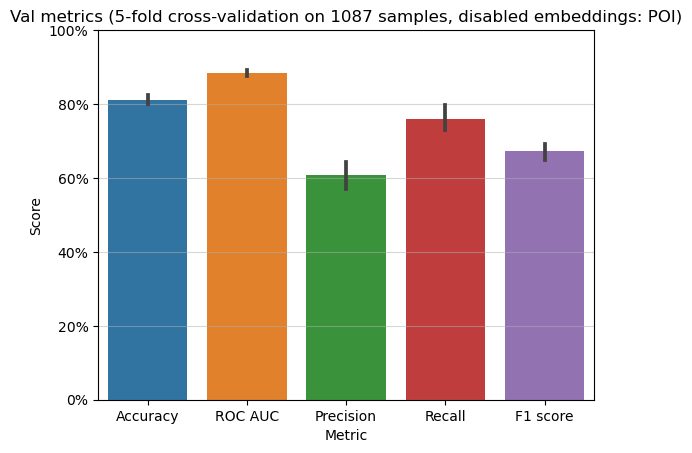

In [31]:
# Plot aggregated results
import seaborn as sns
import matplotlib.pyplot as plt

val_metrics = pd.read_csv(
    f'../data/results/val_metrics_{n_splits}-splits_ablation.csv'
)

for disabled_embeddings in embeddings_to_disable:
    tmp = val_metrics[val_metrics['disabled_embeddings']
                      == ' '.join(disabled_embeddings)].copy()
    tmp = tmp[['fold', 'val_acc', 'val_roc_auc',
               'val_precision', 'val_recall', 'val_f1_score']]
    # Rename columns
    tmp.columns = ['fold', 'Accuracy', 'ROC AUC',
                   'Precision', 'Recall', 'F1 score']
    # Plot aggregated mean value of all metrics in one bar plot
    tmp = tmp.melt(id_vars='fold', var_name='Metric', value_name='Score')
    sns.barplot(data=tmp, x='Metric', y='Score')

    num_data = len(protac_df[protac_df['Active'].notna()])
    plt.title(
        f'Val metrics ({n_splits}-fold cross-validation on {num_data} samples, disabled embeddings: {disabled_embeddings[0].upper()})')
    plt.grid(axis='y', alpha=0.5)
    # Set y-axis to end at 1.0
    plt.ylim(0, 1.0)
    # Make the y-axis as percentage
    plt.gca().yaxis.set_major_formatter(
        plt.matplotlib.ticker.PercentFormatter(1, decimals=0))
    plt.show()

## Psuedo-Label Training

In [69]:
from copy import copy

oracle_model = copy(model)
print(
    f'Number of parameters: {sum(p.numel() for p in oracle_model.parameters()):,}')

Number of parameters: 5,903,617


In [107]:
def get_oracle_predictions(model, trainer, test_df):
    test_ds = PROTAC_Dataset(
        test_df,
        protein_embeddings,
        cell2embedding,
        smiles2fp,
    )
    test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)
    test_preds = trainer.predict(model, test_dl)
    test_preds = torch.vstack(test_preds).numpy().flatten()
    test_df['Active'] = [
        is_active(p, pos_threshold=0.97, neg_threshold=0.001) for p in test_preds]
    return test_df


train_df, val_df = train_test_split(
    protac_df[protac_df['Active'].notna()], test_size=0.2, random_state=42)
test_df = protac_df[protac_df['Active'].isna()]

val_metrics = []
for i in range(5):
    print(f'Oracle iteration {i}')
    model, trainer, metrics = train_model(train_df, val_df)
    val_metrics.append(metrics)
    test_df = get_oracle_predictions(model, trainer, test_df)
    # Update the training set
    train_df = pd.concat([
        train_df,
        test_df[test_df['Active'].notna()]], axis=0).drop_duplicates()
    display(metrics)

Oracle iteration 0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.681


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8119266033172607     │
│       val_f1_score        │    0.6611570119857788     │
│       val_hp_metric       │    0.8119266033172607     │
│         val_loss          │    0.36858928203582764    │
│       val_opt_score       │    1.4730836153030396     │
│       val_precision       │    0.6557376980781555     │
│        val_recall         │    0.6666666865348816     │
│        val_roc_auc        │    0.8914557695388794     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

[{'val_loss': 0.36858928203582764,
  'val_acc': 0.8119266033172607,
  'val_f1_score': 0.6611570119857788,
  'val_hp_metric': 0.8119266033172607,
  'val_opt_score': 1.4730836153030396,
  'val_precision': 0.6557376980781555,
  'val_recall': 0.6666666865348816,
  'val_roc_auc': 0.8914557695388794}]

Oracle iteration 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.680


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8119266033172607     │
│       val_f1_score        │    0.7284768223762512     │
│       val_hp_metric       │    0.8119266033172607     │
│         val_loss          │    0.4363510012626648     │
│       val_opt_score       │    1.5404033660888672     │
│       val_precision       │    0.6043956279754639     │
│        val_recall         │    0.9166666865348816     │
│        val_roc_auc        │    0.8967299461364746     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

[{'val_loss': 0.4363510012626648,
  'val_acc': 0.8119266033172607,
  'val_f1_score': 0.7284768223762512,
  'val_hp_metric': 0.8119266033172607,
  'val_opt_score': 1.5404033660888672,
  'val_precision': 0.6043956279754639,
  'val_recall': 0.9166666865348816,
  'val_roc_auc': 0.8967299461364746}]

Oracle iteration 2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.678


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8486238718032837     │
│       val_f1_score        │    0.7441860437393188     │
│       val_hp_metric       │    0.8486238718032837     │
│         val_loss          │    0.3814685344696045     │
│       val_opt_score       │    1.5928099155426025     │
│       val_precision       │     0.695652186870575     │
│        val_recall         │     0.800000011920929     │
│        val_roc_auc        │    0.9017932415008545     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

[{'val_loss': 0.3814685344696045,
  'val_acc': 0.8486238718032837,
  'val_f1_score': 0.7441860437393188,
  'val_hp_metric': 0.8486238718032837,
  'val_opt_score': 1.5928099155426025,
  'val_precision': 0.695652186870575,
  'val_recall': 0.800000011920929,
  'val_roc_auc': 0.9017932415008545}]

Oracle iteration 3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.665


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8486238718032837     │
│       val_f1_score        │    0.7591241002082825     │
│       val_hp_metric       │    0.8486238718032837     │
│         val_loss          │    0.3775690495967865     │
│       val_opt_score       │     1.607748031616211     │
│       val_precision       │    0.6753246784210205     │
│        val_recall         │    0.8666666746139526     │
│        val_roc_auc        │    0.8989450931549072     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

[{'val_loss': 0.3775690495967865,
  'val_acc': 0.8486238718032837,
  'val_f1_score': 0.7591241002082825,
  'val_hp_metric': 0.8486238718032837,
  'val_opt_score': 1.607748031616211,
  'val_precision': 0.6753246784210205,
  'val_recall': 0.8666666746139526,
  'val_roc_auc': 0.8989450931549072}]

Oracle iteration 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | poi_emb    | Linear     | 787 K 
1 | e3_emb     | Linear     | 787 K 
2 | cell_emb   | Linear     | 590 K 
3 | smiles_emb | Linear     | 787 K 
4 | fc1        | Linear     | 2.4 M 
5 | fc2        | Linear     | 590 K 
6 | fc3        | Linear     | 769   
7 | dropout    | Dropout    | 0     
8 | metrics    | ModuleDict | 0     
------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.614    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.665


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8348624110221863     │
│       val_f1_score        │          0.71875          │
│       val_hp_metric       │    0.8348624110221863     │
│         val_loss          │    0.38852933049201965    │
│       val_opt_score       │     1.553612470626831     │
│       val_precision       │    0.6764705777168274     │
│        val_recall         │    0.7666666507720947     │
│        val_roc_auc        │    0.8900843858718872     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

[{'val_loss': 0.38852933049201965,
  'val_acc': 0.8348624110221863,
  'val_f1_score': 0.71875,
  'val_hp_metric': 0.8348624110221863,
  'val_opt_score': 1.553612470626831,
  'val_precision': 0.6764705777168274,
  'val_recall': 0.7666666507720947,
  'val_roc_auc': 0.8900843858718872}]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

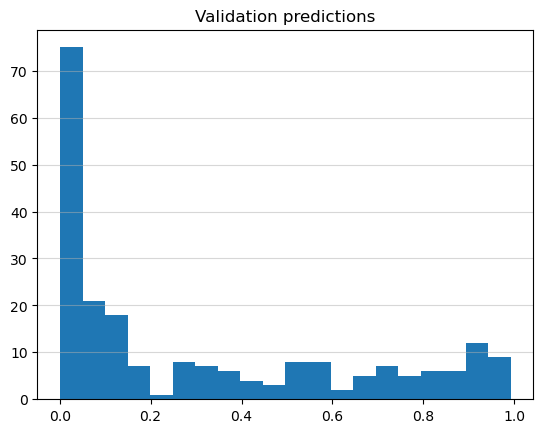

In [108]:
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
val_preds = trainer.predict(model, val_dl)
val_preds = torch.vstack(val_preds).numpy().flatten()

# Plot histogram of predictions
plt.hist(val_preds, bins=20)
plt.title('Validation predictions')
plt.grid(axis='y', alpha=0.5)
plt.show()